In [3]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm_c")
from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import xrft
import netCDF4
import xgcm
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MIT_xr_cwt_dateloc_fol import loadMITData
from MITllc2160Depth import *



from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

ImportError: attempted relative import with no known parent package

In [20]:
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm_c")
from xmitgcm_c.mds_store import openmdsdataset


ModuleNotFoundError: No module named 'xmitgcm_c'

So in this notebook, we're hoping to wrap up an idea of where to integrate vertically to calculate mixed layer temperature variance budget. I'll be trying to do a few things at the same time - 1. I'm going to do a sensitivity study of the budget balance as a function of integration depth and 2. I'm going to look at frequency wavenumber spectra for theta at various depths

In [3]:
%time depthToZlayer(300)

NameError: name 'depthToZlayer' is not defined

In [15]:
zlayerToDepth(30)

251.76999999999998

So we should download 40 layers and do the sum to layer 40 and 38 and compare for the first few months

In [3]:
%time hbl = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'KPPhbl', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer
CPU times: user 53 s, sys: 6.52 s, total: 59.5 s
Wall time: 2min 7s


In [4]:
hblc = hbl.compute()

In [5]:
def coarseGrainHbl_MAX(hblset):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl']
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

In [6]:
%matplotlib inline
hblcm = hblc.max(dim=['lat','lon'])

In [7]:
hblcmcg = coarseGrainHbl_MAX(hblcm)

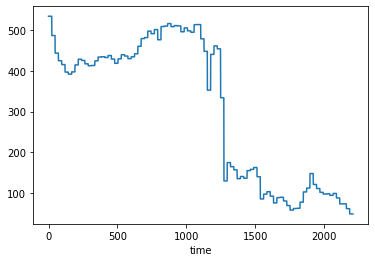

In [8]:
%matplotlib inline
hblcmcg.plot()

In [14]:
xr.where(np.abs(hblcmcg.diff('time') - 88.024) < 0.05, 1,0).data

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
SST = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 0,0 )

In [5]:
SSTc = SST.compute()
SSTc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.43 20.42 20.43 ... 15.25 15.26 15.09

In [5]:
SSTc = SSTc.sel(time=slice(1,-1))

I'm going to start by calculating spectra of SST just for the exercise - I should be able to see some kind of frequency peaks here.

In [6]:
SSTw = SSTc.sel(time=slice(0,1200)) #splitting the variable into the winter and summer regimes
SSTs = SSTc.sel(time=slice(1300,-1))

Spectra and Sums

Sums: I'm going to have to revisit and ideally parallelize all my code for this. That means going back to notebook 14 and doing xarray stuff
1. Figure out the most efficient way to add all these layers accurately.

Spectra: What's the procedure
1. Scale variables to what you want earlier (so days instead of hours for example, km instead of lat lon)
2. Detrend in space and time (fit to trend like Brian says)
3. Window - you'll have to play with xrft to get this part working, especially for normalizing the thing
4. FFT
5. Correctly deal with frequencies 
6. Normalize - the dx normalization is handled by doing true_amplitude
7. Normalize by window
8. Check Parseval's theorem  - do this before making it isotropic
9. Isotropize
10. Plot and add plot labels

In [32]:
#Can we parallelize this summing?
from dask import delayed
T2 = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 1,1 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [37]:
%time sumTest = SST+T2

CPU times: user 9.32 ms, sys: 727 µs, total: 10 ms
Wall time: 9.57 ms


In [71]:
%time Theta = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta',0,30 )

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been 

FileNotFoundError: [Errno 2] No such file or directory: b'/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/Theta_22/Theta_2020041618.nc'

In [72]:
%time Hadv = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv',0,30 )

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been 

FileNotFoundError: [Errno 2] No such file or directory: b'/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/HAdv_22/HAdv_2020052207.nc'

In [89]:
Hadv.HAdv

,Array,Chunk
Bytes,11.10 GiB,878.91 kiB
Shape,"(6, 2208, 300, 375)","(1, 1, 300, 375)"
Count,97152 Tasks,13248 Chunks
Type,float64,numpy.ndarray


In [73]:
T_summer = Theta.Theta[:,1300:-1,:,:]
H_summer = Hadv.HAdv[:,1300:-1,:,:] 

In [74]:
T_savg = getZlayerThickness(0)*T_summer.isel(Zlayers=0)
H_savg = getZlayerThickness(0)*H_summer.isel(Zlayers=0)
for index in range(1,T_summer.Zlayers.size):
    layerthick = getZlayerThickness(25+index)
    T_savg += layerthick*T_summer.isel(Zlayers=index)
    H_savg += layerthick*H_summer.isel(Zlayers=index)
    

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/scheduler.py", line 3862, in heartbeat_worker
    ws._executing = {
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/scheduler.py", line 3863, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: 'open_dataset-039c2f6c-f6bf-4b90-9db6-83fb91da3f97'
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-package

In [75]:
T_s_30 = T_savg 
H_s_30 = H_savg

In [27]:
#T_s_32.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/T_summer_sum25to32.nc4')
%time H_s_30.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/H_summer_sum25to32.nc4')

CPU times: user 4min 3s, sys: 35.6 s, total: 4min 39s
Wall time: 10min 2s


In [26]:
%time T_s_30.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/T_summer_sum25to32.nc4')

CPU times: user 3min 33s, sys: 25.4 s, total: 3min 59s
Wall time: 8min 30s


In [6]:
H_s_30 = xr.open_dataset('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/H_summer_sum25to32.nc4')
T_s_30 = xr.open_dataset('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/T_summer_sum25to32.nc4')

In [28]:
T_s_30

<xarray.DataArray 'Theta' (time: 907, lat: 300, lon: 375)>
dask.array<add, shape=(907, 300, 375), dtype=float64, chunksize=(1, 300, 375), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [15]:
#del T_summer
#del H_summer
#del T_savg
#del H_savg
del Theta
del Hadv

In [29]:
Zeta = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Zeta',0,0 )
Q = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'oceQnet',0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


<xarray.Dataset>
Dimensions:  (lat: 300, lon: 375, time: 1407)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 ...

I DELETED ALL THESE ZETA AND Q FILES BECAUSE THEY DID NOT MATCH THE COORDINATES WE WANTED. SO IN THE MEANWHILE, YOU SHOULD TEST OUT LOADMITDATASET THAT MIGHT BE QUICKER!

In [30]:
Z = Zeta.Zeta[1300:-1]
Qn = Q.oceQnet[1300:-1]

In [31]:
del Zeta
del Q

In [32]:
rhoConst = 1027.5 #kg/m^3
Cp = 1*(10**3) # J / (kg K)

In [76]:
Height = zlayerToDepth(30)

In [37]:
T_s_30

<xarray.DataArray 'Theta' (time: 907, lat: 300, lon: 375)>
dask.array<add, shape=(907, 300, 375), dtype=float64, chunksize=(1, 300, 375), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [43]:
Zt = Z[:,:,1:]
Qt = Qn[:,:,1:]

In [44]:
Zt

<xarray.DataArray 'Zeta' (time: 907, lat: 300, lon: 375)>
dask.array<getitem, shape=(907, 300, 375), dtype=float64, chunksize=(1, 300, 375), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [77]:
ekman30 = Zt*T_s_30 / (Height) #the second height here is to add the correct factor to the summed T, which should have been averaged
heatflux30 = Qt / ( rhoConst * Cp)

In [64]:
hf30 = heatflux30.compute()

In [65]:
e30 = ekman30.compute()


In [78]:
tendency_estimate_30 = ekman30+heatflux30-H_s_30 

In [ ]:
from xmitg

In [69]:
T_s_32

<xarray.DataArray 'Theta' (time: 1407, lat: 300, lon: 375)>
dask.array<add, shape=(1407, 300, 375), dtype=float64, chunksize=(1, 300, 375), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [79]:
tendency_30 = T_s_30.diff('time')

In [80]:
te32 = tendency_estimate_30.compute()

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/scheduler.py", line 3862, in heartbeat_worker
    ws._executing = {
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/scheduler.py", line 3863, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: 'open_dataset-00b637f7-ca37-43b4-9c76-a25d3e356870'
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-package

In [81]:
t30 = tendency_30.compute()

## te30 = te32

In [59]:
te30 

<xarray.DataArray (time: 907, lat: 300, lon: 375)>
array([[[ 1.85824539e-07,  1.85824539e-07,  8.34474372e-07, ...,
          6.60694023e-07,  5.76206963e-07,  8.58249049e-07],
        [ 2.69759829e-07,  2.69759829e-07,  6.36427517e-07, ...,
          7.49599273e-07,  8.88305782e-07,  1.42194025e-06],
        [ 3.38107195e-07,  3.38107195e-07,  3.44600572e-07, ...,
          7.96252478e-07,  9.99037231e-07,  8.58220204e-07],
        ...,
        [ 6.73352413e-07,  6.73352413e-07, -9.68982150e-08, ...,
          2.56957632e-07,  6.21642155e-07, -6.34124526e-07],
        [-2.27752029e-07, -2.27752029e-07,  4.09101961e-07, ...,
          2.14828652e-06,  9.74186173e-07, -7.25774293e-07],
        [ 6.83961276e-07,  6.83961276e-07,  1.36633197e-06, ...,
          1.79013665e-06, -1.53327936e-07, -2.51965431e-07]],

       [[ 2.38792024e-07,  2.38792024e-07,  1.01384245e-06, ...,
          4.57086670e-07,  3.69915734e-07,  4.63603615e-07],
        [ 2.27031413e-07,  2.27031413e-07,  5.34356052e-07, ...,
          7.11192427e-07,  8.55746205e-07,  1.80749552e-06],
        [ 2.44599625e-07,  2.44599625e-07,  7.97561851e-08, ...,
          1.04501523e-06,  1.71503174e-06,  2.34428345e-06],
...
        [-1.00748882e-06, -1.00748882e-06, -6.33116418e-07, ...,
         -6.82283655e-07, -6.75077829e-07, -6.47973683e-07],
        [-8.94317298e-07, -8.94317298e-07, -2.83158944e-07, ...,
         -7.82385155e-07, -6.59678498e-07, -6.01723774e-07],
        [-7.96713699e-07, -7.96713699e-07, -5.72161522e-08, ...,
         -8.37995183e-07, -7.48694283e-07, -5.99860429e-07]],

       [[ 5.90175630e-08,  5.90175630e-08,  1.48778099e-07, ...,
          1.34213625e-07,  1.32399287e-07,  1.29295001e-07],
        [ 4.45474092e-07,  4.45474092e-07,  4.53606477e-07, ...,
          4.93404739e-08,  1.95978814e-07,  1.07499701e-07],
        [ 5.11370964e-08,  5.11370964e-08,  1.64206517e-07, ...,
          5.11830177e-08,  2.12203275e-07,  1.60312049e-08],
        ...,
        [-7.93007155e-07, -7.93007155e-07, -5.57934736e-08, ...,
         -3.35106100e-07, -3.85258769e-07, -3.65480882e-07],
        [-6.94233169e-07, -6.94233169e-07,  8.04595901e-07, ...,
         -3.76252462e-07, -3.27394916e-07, -3.20191730e-07],
        [-1.51950332e-07, -1.51950332e-07,  1.68956505e-06, ...,
         -4.81836986e-07, -4.20677410e-07, -2.80038971e-07]]])
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [58]:
Height

299.505

In [82]:
tscaled30 = t30 / (3600) # you need to get this in terms of K/sec because the tendency estimate has those units

In [83]:
error30 = ((te30[1:]-tscaled30)/tscaled30).sum()

In [84]:
error30

<xarray.DataArray ()>
array(-1.01805687e+08)

In [44]:
error32

<xarray.DataArray (time: 1406, lat: 300, lon: 0)>
array([], shape=(1406, 300, 0), dtype=float64)
Coordinates:
  * lon      (lon) float64 
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
Dimensions without coordinates: time

In [42]:
%time Thsum = Theta.sum('Zlayers')

CPU times: user 387 ms, sys: 1.05 ms, total: 388 ms
Wall time: 437 ms


In [43]:
Thsum

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 dask.array<chunksize=(1, 300, 625), meta=np.ndarray>

In [58]:
SSTw

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 600)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.43 20.42 20.43 ... 13.27 13.21 13.19

-------------------------------------------------------------------------------------------------------
Below here we'll separate out the spectral stuff

In [16]:
#testing xrft function isotropic power spectrum
#SSTw_xc = xrft.xrft.isotropic_power_spectrum(SSTw.Theta, dim = ['lat','lon'], real_dim = ['lat','lon'], detrend='linear', window='tukey', window_correction=True,truncate=True)
SSTw_x = xrft.xrft.power_spectrum(SSTw.Theta, dim = 'lat', real_dim = 'lat', detrend='linear', window='tukey', window_correction=True,truncate=True)
SSTw_xc = xrft.xrft.power_spectrum(SSTw_x, dim = 'lon', real_dim='lon',detrend='linear', window='tukey', window_correction=True,truncate=True)

In [21]:
from spectral_analysis_code import *
SSTw_xc = isotropize(SSTw_xc, ['freq_lat', 'freq_lon'], 'time')

In [ ]:
#you successfully downloaded isotropize there is a good chance you can use xrft.isotropizeb

In [22]:
SSTw_xct = xrft.xrft.power_spectrum(SSTw_xc, dim = ['time',], real_dim='time', detrend='linear', window='tukey', window_correction=True,truncate=True)

In [9]:
SSTw_xct

<xarray.DataArray (freq_time: 301, freq_r: 53)>
array([[2.72786661e-02, 3.27521645e-04, 9.08771547e-05, ...,
        1.25249155e-10, 4.49470215e-11, 8.83595786e-11],
       [9.59934074e-02, 4.81993009e-03, 5.03731873e-04, ...,
        1.28322634e-10, 1.57693394e-10, 2.33868227e-10],
       [6.13203494e-02, 4.02886931e-03, 6.21608904e-04, ...,
        1.72589353e-09, 1.22969868e-09, 1.40941255e-09],
       ...,
       [1.57765666e-09, 5.05609722e-10, 5.94591388e-11, ...,
        2.49614493e-15, 1.80336808e-15, 1.54660340e-15],
       [6.21137201e-09, 7.52597533e-10, 2.14589428e-10, ...,
        8.12102524e-16, 2.90298431e-16, 4.57768359e-16],
       [1.10318577e-08, 2.67675762e-09, 1.18574628e-10, ...,
        1.32015002e-15, 2.05282125e-16, 1.02880111e-15]])
Coordinates:
  * freq_r     (freq_r) float64 0.1544 0.3651 0.5967 0.8316 ... 11.9 12.13 12.36
  * freq_time  (freq_time) float64 0.0 0.001667 0.003333 ... 0.4967 0.4983 0.5

In [10]:
SSTw_xct.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/SST_March_komega')

In [11]:
SSTw.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/SST_March')

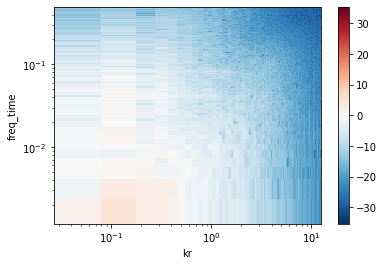

In [40]:
%matplotlib inline
np.log(SSTw_xct[1:-1]).plot(xscale = 'log', yscale = 'log')

In [10]:
%matplotlib inline
SSTw_xctap = SSTw_xct * SSTw_xct.freq_time * SSTw_xct.freq_r

In [21]:
lSSTw_xctap = np.log(SSTw_xctap)/np.log(10)

In [23]:
lSSTw_xctap_w = xr.where(lSSTw_xctap > -10, lSSTw_xctap, 0)

In [1]:
%matplotlib inline
lSSTw_xctap[1:-1].plot(xscale = 'log', yscale = 'log')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [26]:
SSTs = SSTs.sel(time=slice(0,-1)).isel(lon=slice(0,-1))

In [27]:
#testing xrft function isotropic power spectrum
SSTs_xc = xrft.xrft.isotropic_power_spectrum(SSTs.Theta, dim = ['lat','lon'], detrend='linear', window='tukey', window_correction=True,truncate=True)

In [ ]:
#you successfully downloaded isotropize there is a good chance you can use xrft.isotropizeb

In [28]:
SSTs_xct = xrft.xrft.power_spectrum(SSTs_xc, dim = ['time',], real_dim='time', detrend='linear', window='tukey', window_correction=True,truncate=True)

In [29]:
SSTs_xctap = SSTs_xct * SSTs_xct.freq_time * SSTs_xct.freq_r

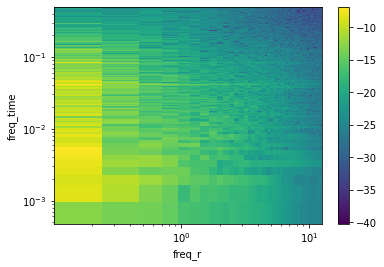

In [30]:
%matplotlib inline
np.log(SSTs_xctap[1:-1]).plot(xscale = 'log', yscale = 'log')

In [ ]:
# trying he

In [98]:
#This seems unlikely but we should test this function against some known output

#You should also compare to your own code or Hector's

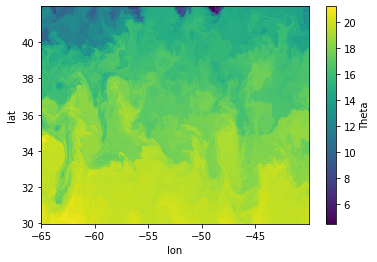

In [99]:
SSTc.Theta[10].plot()

In [ ]:
#I'm going to look for the energy peaks in the advection stuff
#WELL, the advection stuff did not produce the expected result so I will try something else

This is code to interpolate to spatial coordinates

In [ ]:
earthrad = 6371229     # mean earth radius (m)

deg2rad = np.pi / 180.

 

def _e1e2(navlon,navlat):

    """Compute scale factors from navlon,navlat.

        """

    lam = navlon

    phi = navlat

    djlam,dilam = np.gradient(lam)

    djphi,diphi = np.gradient(phi)

    e1 = earthrad * deg2rad * np.sqrt( (dilam * np.cos(deg2rad*phi))**2. + diphi**2.)

    e2 = earthrad * deg2rad * np.sqrt( (djlam * np.cos(deg2rad*phi))**2. + djphi**2.)

    return e1,e2

 

#########################

def interpolate(data,navlon,navlat,interp=None):

    """

        Perform a spatial interpolation if required; return x_reg,y_reg,data_reg.

        data : raw data

        nalon : longitude

        navlat : latitude

        interp : if None return data with cordinates in meters, if 'basemap', return interpolated

        data using basemap from mpl_toolkits and also cordinates in meters.

        """

    e1,e2 = _e1e2(navlon,navlat)

    x1d_in = e1[0,:].cumsum() - e1[0,0]

    y1d_in = e2[:,0].cumsum() - e2[0,0]

    x2d_in,y2d_in = np.meshgrid(x1d_in,y1d_in)

    # print x1d_in

    if interp is None :

        return x2d_in, y2d_in, data

    elif interp=='basemap': # only for rectangular grid...

        from mpl_toolkits import basemap

        x1d_reg=np.linspace(x1d_in[0],x1d_in[-1],len(x1d_in))

        y1d_reg=np.linspace(y1d_in[0],y1d_in[-1],len(y1d_in))

        x2d_reg,y2d_reg = np.meshgrid(x1d_reg,y1d_reg)

        data_reg=basemap.interp(data,x1d_in,y1d_in,x2d_reg,y2d_reg,checkbounds=False,order=1)

        return x2d_reg,y2d_reg,data_reg

    else: raise ValueError('Your choice of interp is not available in this sript.')

In [ ]:
#an easier way to go from longitude to latitude
longtokm = 110.574 #km/deg
lattokm = 111.320 * np.cos(latitude) #km/deg

In [23]:
#let's rescale with this for SST winter
SSTw

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 600)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.43 20.42 20.43 ... 13.27 13.21 13.19

In [26]:
oldSSTtime = SSTw.time
oldSSTtime
newSSTtime = oldSSTtime * 1/24.0 # hours * 1day/24hrs

In [29]:
oldSSTlat = SSTw.lat
oldSSTlatmean = np.mean(oldSSTlat)
newSSTlattokm = oldSSTlat  * 110.574 #deg * km/deg

In [30]:
oldSSTlon = SSTw.lon
oldSSTlonmean = np.mean(oldSSTlon)
newSSTlontokm = oldSSTlon * 111.320 * np.cos(oldSSTlatmean) #deg * km/deg

In [37]:
SSTw_rescaled = xr.DataArray(SSTw.Theta.values, dims=['time','ydim','xdim'], coords = [oldSSTtime, newSSTlattokm, newSSTlontokm], name='March SST')

In [39]:
SSTw_rescaled

<xarray.DataArray 'March SST' (time: 600, ydim: 300, xdim: 625)>
array([[[20.42859459, 20.41896248, 20.42638779, ..., 19.84677315,
         19.8549099 , 19.86591911],
        [20.44911766, 20.42672539, 20.42494202, ..., 19.94408417,
         19.94595146, 19.93398857],
        [20.46592903, 20.43584633, 20.42579079, ..., 19.96326637,
         19.9447422 , 19.9281826 ],
        ...,
        [11.91206741, 11.91426849, 11.91246033, ..., 12.75244331,
         12.74405289, 12.72519302],
        [11.74731636, 11.80148411, 11.86221886, ..., 12.85364914,
         12.81610775, 12.79233456],
        [10.82258987, 10.95289326, 11.08449268, ..., 12.83702087,
         12.80776405, 12.80819416]],

       [[20.42792511, 20.41682053, 20.42404175, ..., 19.82388115,
         19.83141899, 19.84191704],
        [20.44855881, 20.42505836, 20.42313385, ..., 19.92331886,
         19.9272213 , 19.91727829],
        [20.46560669, 20.43463707, 20.424366  , ..., 19.94804382,
         19.92947197, 19.91534233],
...
        [11.20053291, 11.23190212, 11.22991562, ..., 13.17353153,
         13.19696903, 13.22269535],
        [10.67332077, 10.66965675, 10.65374279, ..., 13.19131279,
         13.16869354, 13.16786385],
        [10.21253681, 10.20896244, 10.20241165, ..., 13.26932144,
         13.20745468, 13.18641472]],

       [[19.95703125, 19.78986168, 20.28317451, ..., 19.54124832,
         19.54688454, 19.54231262],
        [19.85799599, 19.77590942, 20.15574837, ..., 19.54727554,
         19.54994202, 19.54250717],
        [19.81402969, 19.79481316, 20.03915215, ..., 19.54210091,
         19.55656815, 19.55474663],
        ...,
        [11.3228302 , 11.38942432, 11.40312386, ..., 13.16482449,
         13.18340969, 13.20476341],
        [10.85826778, 10.88655281, 10.84581375, ..., 13.18982124,
         13.16038799, 13.15433502],
        [10.27006149, 10.27147102, 10.23897934, ..., 13.27342033,
         13.20791245, 13.18721962]]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 24.88 24.92 24.96
  * ydim     (ydim) float64 3.317e+03 3.322e+03 3.326e+03 ... 4.635e+03 4.64e+03
  * xdim     (xdim) float64 1.069e+03 1.069e+03 1.068e+03 ... 660.0 659.3 658.7

In [131]:
SSTw_kl = xrft.xrft.isotropic_power_spectrum(SSTw_rescaled, dim = ['ydim','xdim'], detrend='linear', window='hann', window_correction=True,truncate=True, true_amplitude = True)

In [59]:
#from spectral_analysis_code import *
#SSTw_K = xrft.xrft.isotropize(SSTw_kl, ['freq_ydim', 'freq_xdim'])
#SSTw_K

<xarray.DataArray (time: 600, freq_r: 37)>
array([[1.02707543e+03, 2.23716156e+02, 4.29786949e+01, ...,
        7.80968459e-02, 5.76663357e-02, 7.52113322e-02],
       [1.02803961e+03, 2.24042076e+02, 4.33074596e+01, ...,
        6.77703696e-02, 5.22181038e-02, 8.35921527e-02],
       [1.02840246e+03, 2.24574998e+02, 4.37750563e+01, ...,
        6.26178084e-02, 5.15056366e-02, 9.66910262e-02],
       ...,
       [1.84958041e+03, 1.78397935e+02, 1.01425404e+02, ...,
        1.57836428e-01, 1.18731422e-01, 8.48075564e-02],
       [1.90327449e+03, 1.82220024e+02, 1.00925023e+02, ...,
        1.54682031e-01, 1.10093063e-01, 7.78888395e-02],
       [1.93396742e+03, 1.84254725e+02, 9.95322021e+01, ...,
        1.40016783e-01, 9.61933125e-02, 7.44699410e-02]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 24.88 24.92 24.96
  * freq_r   (freq_r) float64 0.01351 0.03226 0.05255 ... 0.7152 0.7359 0.7546

In [132]:
SSTw_Komega = xrft.xrft.power_spectrum(np.real(SSTw_kl), dim = ['time',], real_dim='time', detrend='linear', window='hann', window_correction=True,truncate=True, true_amplitude = True)

In [133]:
SSTw_Komega

<xarray.DataArray (freq_time: 301, freq_r: 11)>
array([[8.54141908e-01, 3.17671676e-04, 4.26853957e-03, ...,
        8.67488766e-06, 2.04705333e-08, 5.22608472e-07],
       [2.43550968e+00, 3.00798157e-04, 9.94195577e-03, ...,
        1.62974329e-04, 4.69323281e-06, 1.09975515e-05],
       [2.47838810e+00, 2.11684739e-03, 6.24046421e-03, ...,
        1.80217310e-04, 2.45329926e-05, 2.59522709e-05],
       ...,
       [2.48192867e-07, 1.08285126e-09, 3.62576656e-09, ...,
        2.33410313e-11, 3.42427575e-11, 2.31294508e-10],
       [6.21315999e-07, 1.12654142e-08, 1.18363424e-08, ...,
        3.35036894e-11, 1.21936080e-10, 4.12171345e-10],
       [4.81544214e-07, 2.61118783e-08, 6.91340210e-09, ...,
        3.12088191e-11, 5.24656528e-12, 1.38309476e-10]])
Coordinates:
  * freq_r     (freq_r) float64 0.00689 0.01599 0.02592 ... 0.09724 0.1075
  * freq_time  (freq_time) float64 0.0 0.04 0.08 0.12 ... 11.88 11.92 11.96 12.0

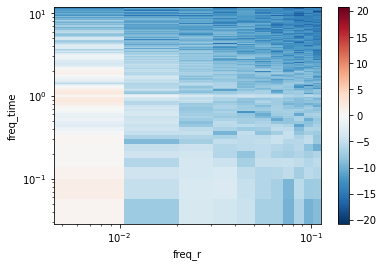

In [134]:
%matplotlib inline
domega = SSTw_Komega.freq_r[1]-SSTw_Komega.freq_r[0]
dK = SSTw_Komega.freq_time[1]-SSTw_Komega.freq_time[0]
SSTw_Komega_var = SSTw_Komega *SSTw_Komega.freq_r*SSTw_Komega.freq_time * (1/(dK*domega))


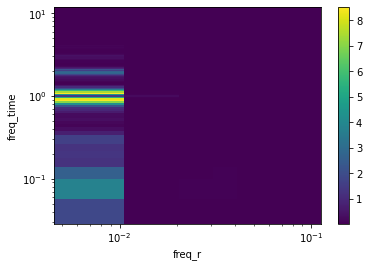

In [135]:
(np.log(SSTw_Komega_var[1:-1]).plot(xscale = 'log', yscale = 'log')

In [73]:
SSTw_time = SSTw.Theta.mean(dim=['lat','lon'])

In [78]:
SSTw_time

<xarray.DataArray 'Theta' (time: 600)>
array([17.22627991, 17.22066552, 17.21590826, 17.2118334 , 17.20834818,
       17.2053469 , 17.20266057, 17.20020203, 17.19795767, 17.19591788,
       17.19489727, 17.19948797, 17.21441779, 17.24343025, 17.28665572,
       17.33874936, 17.3907332 , 17.43396654, 17.46042227, 17.46279618,
       17.43846389, 17.39800804, 17.36003275, 17.32931246, 17.30321596,
       17.28128436, 17.2633911 , 17.24909926, 17.23799977, 17.22962242,
       17.22323905, 17.21819037, 17.214181  , 17.21097907, 17.20931655,
       17.21307234, 17.22611285, 17.25052173, 17.28535487, 17.32565995,
       17.36506483, 17.39726658, 17.41608381, 17.41643387, 17.39794633,
       17.36792453, 17.33918355, 17.3180418 , 17.30182893, 17.28856571,
       17.27753828, 17.26829535, 17.26056007, 17.25406458, 17.24863033,
       17.24415415, 17.24050598, 17.23752411, 17.23589319, 17.23974731,
       17.25232337, 17.27369716, 17.30089617, 17.32881516, 17.3526173 ,
       17.36806545, 17.37118655, 17.36107386, 17.34054434, 17.31720732,
       17.29948564, 17.28853402, 17.28116026, 17.27560631, 17.27113111,
       17.26739618, 17.26414225, 17.26126278, 17.25857506, 17.25592848,
       17.25337303, 17.25090484, 17.24937821, 17.25306768, 17.26490112,
       17.28513161, 17.31142433, 17.33915947, 17.36299575, 17.37818817,
       17.3815826 , 17.37128965, 17.34899757, 17.32223493, 17.30165933,
       17.28878336, 17.27989155, 17.2729431 , 17.26722353, 17.26232414,
...
       17.42128799, 17.38795061, 17.35528053, 17.33258745, 17.31674985,
       17.3046782 , 17.29525417, 17.28775164, 17.28167833, 17.27663174,
       17.27238193, 17.26875753, 17.26561643, 17.26295132, 17.2628595 ,
       17.26962038, 17.28580917, 17.31258222, 17.34770415, 17.38625412,
       17.42200493, 17.44842972, 17.46024833, 17.45482186, 17.43173371,
       17.39728254, 17.3660439 , 17.34472859, 17.3294849 , 17.31732001,
       17.3071106 , 17.29837518, 17.29090458, 17.28456176, 17.27920127,
       17.27474441, 17.27096955, 17.26787027, 17.26749098, 17.27413346,
       17.2901764 , 17.31595167, 17.34944738, 17.38589795, 17.42032536,
       17.44730722, 17.46154585, 17.45972721, 17.44068781, 17.40952127,
       17.37891891, 17.35662992, 17.3403616 , 17.32753266, 17.31715493,
       17.30853282, 17.30127213, 17.29511529, 17.2899422 , 17.28577893,
       17.28244793, 17.27967439, 17.27967837, 17.28743064, 17.30557526,
       17.33525246, 17.37527843, 17.42117607, 17.46626313, 17.50369361,
       17.52773028, 17.53317936, 17.5173597 , 17.4830457 , 17.44536557,
       17.41564699, 17.39270205, 17.37381536, 17.35779442, 17.34389644,
       17.33184874, 17.32153516, 17.31298988, 17.30605179, 17.30045795,
       17.29601493, 17.29498769, 17.30223681, 17.32075494, 17.35206082,
       17.393242  , 17.4381577 , 17.47907868, 17.50784763, 17.5177069 ,
       17.50619654, 17.47520197, 17.4330931 , 17.39548651, 17.37070798])
Dimensions without coordinates: time

In [87]:
oldSSTtime = SSTw_time.time
newSSTtime = oldSSTtime * 1/24.0 # hours * 1day/24hrs
SSTw_time2 = xr.DataArray(SSTw_time.values, dims='time2', coords=[newSSTtime])

In [90]:
SSTw_time2.time2

<xarray.DataArray 'time2' (time2: 600)>
array([ 0.      ,  0.041667,  0.083333, ..., 24.875   , 24.916667, 24.958333])
Coordinates:
  * time2    (time2) float64 0.0 0.04167 0.08333 0.125 ... 24.88 24.92 24.96

In [ ]:
SST

In [102]:
SSTw_omega = xrft.xrft.power_spectrum(SSTw_time2, dim = ['time2',], real_dim='time2', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)

In [105]:
SSTw_omega

<xarray.DataArray (freq_time2: 301)>
array([4.73996193e-04, 3.92380770e-03, 5.86338994e-04, 4.05929573e-03,
       7.23825401e-03, 5.59973798e-04, 7.05546571e-04, 7.96456754e-05,
       1.69306752e-04, 2.10739146e-04, 1.31647454e-04, 2.73641964e-04,
       5.15104699e-05, 1.01618260e-04, 1.41036603e-04, 2.97012974e-05,
       1.41287733e-04, 5.73188161e-05, 3.64102906e-05, 2.09094423e-04,
       3.47801843e-04, 1.08246066e-03, 1.37943323e-03, 9.90948550e-04,
       8.53571134e-03, 7.41825280e-02, 7.94948015e-03, 5.35599576e-04,
       1.51787179e-03, 8.33348164e-04, 1.38377937e-04, 7.05837258e-05,
       1.51066496e-05, 2.47809039e-05, 3.75176382e-05, 1.27246361e-05,
       3.60732931e-05, 8.20928174e-06, 1.38164827e-05, 3.22832755e-05,
       8.55030730e-06, 1.93311847e-05, 1.48922568e-06, 1.04092369e-06,
       3.45863123e-05, 5.71743293e-05, 8.54329903e-05, 1.18518531e-04,
       2.85185443e-04, 1.01596151e-03, 1.02276312e-02, 1.06059022e-03,
       1.17683515e-04, 1.76541717e-04, 1.14298232e-04, 2.24606600e-05,
       8.21432367e-06, 1.14253540e-06, 4.70989984e-06, 6.58316027e-06,
       2.61316830e-07, 4.41107825e-06, 2.88672866e-07, 1.92038849e-06,
       3.16512028e-06, 1.07535835e-06, 1.31103861e-06, 1.30771116e-07,
       2.26099220e-07, 9.76566770e-07, 4.80598802e-06, 4.60309256e-06,
       6.98390692e-06, 1.90071918e-05, 6.74957326e-05, 5.24885468e-04,
       5.17870988e-05, 4.64513780e-06, 7.36687063e-06, 5.45610129e-06,
...
       1.15107244e-08, 5.29966078e-08, 3.63185912e-09, 1.49511405e-09,
       3.33848555e-10, 2.38224844e-10, 8.82352486e-11, 6.69602487e-11,
       1.57454489e-10, 7.95044309e-10, 3.52667151e-11, 6.68801536e-11,
       1.72622807e-10, 1.47786002e-10, 2.12310712e-10, 3.67143087e-11,
       1.65919342e-10, 2.36871357e-10, 3.43951353e-10, 4.95244194e-11,
       8.57785566e-11, 3.24418093e-10, 1.51815967e-10, 1.34752775e-10,
       3.94158562e-10, 1.55220954e-09, 7.62926533e-09, 8.02059122e-10,
       1.25532016e-11, 9.72768002e-10, 3.71983783e-10, 1.37240134e-10,
       1.09026491e-10, 3.93392874e-11, 1.32071585e-10, 1.14123121e-10,
       3.24587532e-10, 4.24763802e-10, 1.89253276e-10, 1.38947549e-11,
       6.69524239e-11, 2.53300716e-11, 2.48403521e-11, 7.75918288e-11,
       4.87740046e-11, 9.14127144e-13, 3.52124687e-10, 3.30581031e-10,
       2.63406677e-10, 2.69990739e-10, 1.53611500e-09, 7.05265981e-09,
       1.02237125e-09, 2.44783427e-10, 3.08537378e-10, 1.66958676e-10,
       4.15169774e-10, 1.77768988e-10, 1.32064673e-10, 3.53332182e-11,
       3.42814927e-11, 1.84404379e-10, 5.32596528e-10, 8.60728240e-11,
       8.08309723e-11, 1.11448648e-10, 1.31305129e-11, 6.54925074e-12,
       7.45218515e-11, 1.80756253e-10, 2.42136601e-10, 8.26587161e-10,
       5.85283268e-10, 5.75260962e-10, 1.06148196e-10, 1.42666099e-10,
       4.51097063e-11])
Coordinates:
  * freq_time2  (freq_time2) float64 0.0 0.04 0.08 0.12 ... 11.92 11.96 12.0

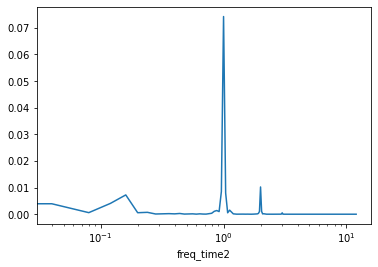

In [103]:
SSTw_omega.plot(xscale = 'log')

In [106]:
dt = SSTw_time2.diff('time2').mean()
df = SSTw_omega.diff('freq_time2').mean()

In [110]:
(SSTw_time2*SSTw_time2*dt).sum('time2')

<xarray.DataArray ()>
array(43.35564056)

In [111]:
(SSTw_omega*np.conjugate(SSTw_omega)).sum('freq_time2')

<xarray.DataArray ()>
array(0.00583972)

In [118]:
SSTw_time_prime = xrft.detrend(SSTw_time, dim='time', detrend_type='linear')

In [119]:
(SSTw_time_prime*SSTw_time_prime).sum()

<xarray.DataArray 'Theta' ()>
array(3.17018424)

In [120]:
SSTw_omega = xrft.xrft.power_spectrum(SSTw_time, dim = ['time',], real_dim='time', detrend='linear',truncate=True, true_amplitude = True)

In [121]:
SSTw_omega.sum()

<xarray.DataArray ()>
array(3.17018424)

In [3]:
#I'm going to try to do this with kinetic energy like Brian suggested
U = getMITNCDataSet('/nobackup/amondal/NCData/20211213_spectra_practice/', 'U', 0,0 )
V = getMITNCDataSet('/nobackup/amondal/NCData/20211213_spectra_practice/', 'V', 0,0 ) 

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [3]:
%matplotlib inline
U.U[0]

<xarray.DataArray 'U' (lat: 300, lon: 600)>
dask.array<getitem, shape=(300, 600), dtype=float64, chunksize=(300, 600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -64.0 -63.96 -63.92 -63.88 ... -40.12 -40.08 -40.04

In [37]:
U.U

<xarray.DataArray 'U' (time: 2208, lat: 300, lon: 600)>
dask.array<concatenate, shape=(2208, 300, 600), dtype=float64, chunksize=(1, 300, 600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -64.0 -63.96 -63.92 -63.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time

In [4]:
E = (U.U**2 + V.V**2)*0.5 #Kinetic energy density

In [5]:
oldtime = E.time
oldtime
newtime = oldtime * 1/24.0 # hours * 1day/24hrs

In [6]:
oldlat = E.lat
oldlatmean = np.mean(oldlat)
newlattokm = oldlat  * 110.574 #deg * km/deg

In [7]:
oldlon = E.lon
oldlonmean = np.mean(oldlon)
newlontokm = oldlon * 111.320 * np.cos(oldlatmean) #deg * km/deg

In [8]:
%time En = xr.DataArray(E.values, dims=['time','lat','lon'], coords=[newtime,newlattokm,newlontokm])

CPU times: user 23.7 s, sys: 17.3 s, total: 41.1 s
Wall time: 43.4 s


In [9]:
En

<xarray.DataArray (time: 2208, lat: 300, lon: 600)>
array([[[0.01827522, 0.01827522, 0.02032629, ..., 0.01359435,
         0.01194377, 0.01045383],
        [0.02187567, 0.02187567, 0.02004344, ..., 0.01528519,
         0.01375392, 0.01279825],
        [0.02374021, 0.02374021, 0.0213127 , ..., 0.02032932,
         0.01671998, 0.01436583],
        ...,
        [0.06505886, 0.06505886, 0.0620556 , ..., 0.01682821,
         0.01243733, 0.01327256],
        [0.09336032, 0.09336032, 0.06948365, ..., 0.02318682,
         0.01712659, 0.01634605],
        [0.09670779, 0.09670779, 0.06419578, ..., 0.02757033,
         0.02096888, 0.01903731]],

       [[0.01855085, 0.01855085, 0.01902205, ..., 0.01345954,
         0.01218708, 0.0127434 ],
        [0.02054317, 0.02054317, 0.01815867, ..., 0.01223157,
         0.01094002, 0.01154496],
        [0.02131748, 0.02131748, 0.0178162 , ..., 0.01463007,
         0.01162493, 0.01073349],
...
        [0.06257947, 0.06257947, 0.09625895, ..., 0.03055386,
         0.0153176 , 0.00548579],
        [0.08322392, 0.08322392, 0.12771341, ..., 0.03928393,
         0.01911311, 0.00658325],
        [0.09846819, 0.09846819, 0.14308694, ..., 0.04313076,
         0.02149004, 0.00855386]],

       [[0.1004077 , 0.1004077 , 0.10153761, ..., 0.01262444,
         0.01436706, 0.01583568],
        [0.0915987 , 0.0915987 , 0.08994921, ..., 0.01966657,
         0.020814  , 0.02296601],
        [0.07551433, 0.07551433, 0.07588053, ..., 0.02376634,
         0.02021071, 0.02039879],
        ...,
        [0.08594444, 0.08594444, 0.10702376, ..., 0.03426046,
         0.0160861 , 0.0034752 ],
        [0.09929368, 0.09929368, 0.12216396, ..., 0.04075756,
         0.0207441 , 0.0058511 ],
        [0.11312386, 0.11312386, 0.13830143, ..., 0.0405428 ,
         0.02078486, 0.00805589]]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 91.88 91.92 91.96
  * lat      (lat) float64 3.317e+03 3.322e+03 3.326e+03 ... 4.635e+03 4.64e+03
  * lon      (lon) float64 1.053e+03 1.052e+03 1.051e+03 ... 660.0 659.3 658.7

So there is a way to do parallelized Bartlet's method with xrft. Welch's method is Bartlett's just with overlapping chunks. I can achieve bartlett's Welch's method by padding the original xaray with part of itself so that the "overlapped chunks" become part of the original xarray. 

In [47]:
En_klom = xrft.xrft.fft(En, dim = ['lat','lon'], real_dim = 'lon', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)
#En_kl = xrft.xrft.fft(En_k, dim = 'lon', real_dim = 'lon', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)

In [36]:
En_kl

<xarray.DataArray (time: 2208, freq_lat: 151, freq_lon: 301)>
array([[[-1.93943898e+02+0.00000000e+00j,
          2.41266046e+02+2.88161691e+02j,
         -2.03374757e+02-6.11357623e+02j, ...,
          1.28586706e+00+4.99725653e-01j,
         -1.25632033e-01-1.79141209e+00j,
         -1.41582301e+00+0.00000000e+00j],
        [-2.23226885e+02+0.00000000e+00j,
          1.42678101e+02+5.10021184e+02j,
          3.18340929e+02+4.82680901e+02j, ...,
         -2.14699645e+00+1.13223034e+00j,
          5.61499461e-01+1.40634840e+00j,
          2.10115655e+00+0.00000000e+00j],
        [ 1.72379596e+02+0.00000000e+00j,
          7.86463303e+01-9.05693152e+02j,
         -5.80713072e+02+2.62616789e+02j, ...,
          2.15195234e+00-3.42573789e+00j,
         -3.72042286e-01-5.74341502e-01j,
         -1.99667093e+00+0.00000000e+00j],
        ...,
        [-1.52871919e+00+0.00000000e+00j,
...
          4.21214795e-02+0.00000000e+00j],
        ...,
        [ 2.56589649e+00+0.00000000e+00j,
          6.73027802e+00+1.71261291e+00j,
         -9.23505631e+00-1.80446272e-01j, ...,
         -9.28497680e-01-5.17703796e-01j,
          1.94387930e-01+2.71137307e-01j,
         -1.61334820e-01+0.00000000e+00j],
        [ 4.33961323e+00+0.00000000e+00j,
         -1.53881853e+01-5.13438844e+00j,
          1.36418007e+01+3.41524418e+00j, ...,
         -5.91274652e-02-4.95973940e-01j,
         -5.27815537e-02+3.61188943e-01j,
          9.49548375e-02+0.00000000e+00j],
        [-1.46647127e+01+0.00000000e+00j,
          1.77551225e+01+6.49029374e+00j,
         -8.76161472e+00-4.61419803e-01j, ...,
          5.84317104e-01+8.13379070e-01j,
          2.01090871e-01-2.25053616e-01j,
         -5.38856030e-01+0.00000000e+00j]]])
Coordinates:
  * time      (time) float64 0.0 0.04167 0.08333 0.125 ... 91.88 91.92 91.96
  * freq_lat  (freq_lat) float64 0.0 0.0007536 0.001507 ... 0.1115 0.1123 0.113
  * freq_lon  (freq_lon) float64 0.0 0.002533 0.005066 ... 0.7548 0.7573 0.7599

In [37]:
from spectral_analysis_code import *
En_K = isotropize(En_kl, ['freq_lat', 'freq_lon'], 'time')

In [38]:
En_K

<xarray.DataArray (time: 2208, kr: 44)>
array([[ 0.48923388, -0.45949792,  0.25237238, ..., -0.06557092,
        -0.09269021, -0.14418992],
       [ 0.45566132, -0.35409402,  0.27700606, ..., -0.02785391,
        -0.10851911, -0.17756242],
       [ 0.41294257, -0.32209494,  0.25320141, ..., -0.01307681,
        -0.08635909, -0.23447938],
       ...,
       [-1.10120175, -0.28511761,  0.86624219, ...,  0.00307165,
        -0.08304578,  0.04036864],
       [-1.12155372, -0.33270289,  0.94229061, ...,  0.02120655,
        -0.0780439 ,  0.08345256],
       [-1.10926016, -0.43250866,  0.97290163, ...,  0.05108641,
        -0.06645867,  0.08757269]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 91.88 91.92 91.96
  * kr       (kr) float64 0.001321 0.003964 0.006607 ... 0.1097 0.1123 0.115

In [39]:
#Now, to try Bartlett's method
n = En_K.time.size
En_Kom = xrft.xrft.power_spectrum(En_K.chunk({'time':int(n/4)}), dim=['time'], chunks_to_segments=True, real_dim = 'time', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)

In [40]:
En_Kom_dom = En_Kom / En_Kom['freq_time'].spacing
# So that was pain free but you need to figure out how to make time register in cpd instead of 
#cph like it seems to want to 

In [41]:
En_Kom_bar = En_Kom_dom.mean('time_segment').compute()

In [42]:
En_Kom_bar

<xarray.DataArray (freq_time: 277, kr: 44)>
array([[5.61027285e-01, 5.04754530e+00, 4.21436421e+00, ...,
        7.61895305e-02, 1.58258474e-02, 2.20320831e-02],
       [8.21500598e+00, 2.22404721e+01, 3.91749254e+01, ...,
        5.54624778e-01, 1.55995547e-01, 6.53794740e-01],
       [3.68310651e+00, 8.77687026e+00, 2.10981210e+01, ...,
        5.96792881e-01, 1.30682382e-01, 5.43302535e-01],
       ...,
       [8.86999219e-06, 1.99803885e-05, 9.31874994e-05, ...,
        2.96238994e-05, 2.27248179e-05, 2.03295613e-05],
       [7.07139558e-06, 3.08254981e-05, 8.14431477e-05, ...,
        2.34239573e-05, 1.41330186e-05, 2.39663912e-05],
       [2.59831659e-06, 1.85037732e-05, 1.22999084e-04, ...,
        1.82202835e-05, 9.82377569e-06, 1.19441855e-05]])
Coordinates:
  * kr         (kr) float64 0.001321 0.003964 0.006607 ... 0.1097 0.1123 0.115
  * freq_time  (freq_time) float64 0.0 0.04348 0.08696 ... 11.91 11.96 12.0

In [43]:
# variance preserving form
En_Kom_bar_vp = En_Kom_bar * En_Kom_bar.kr * En_Kom_bar.freq_time

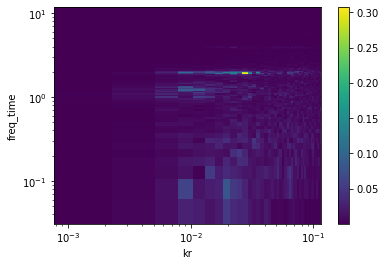

In [45]:
%matplotlib inline
En_Kom_bar_vp[1:-1].plot(xscale = 'log', yscale = 'log')